In [871]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
import re
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
%matplotlib inline
plt.style.use('default')

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")


✅ All libraries imported successfully!
📊 Pandas version: 2.3.2
🔢 NumPy version: 2.3.3


## Step 1: Load the data and perform exploratory data analysis

- Loading the training dataset and training dataset, merge them into one to ensure the preprocessing for attributes is same along the way
- Looking at the top 5 rows
- Checking the description of the columns
- Checking for na values in any of the columns
- Look at the number of unique values of categorical variables to explore encoding options

In [872]:
# concatenate train and test data on the columns 
def concat_train_test(train_path, test_path):
    # 1. Load data
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # 2. Add missing target column to test (expected to be NaN)
    test['Transacted Price ($)'] = np.nan
    
    # 3. Add source tracking
    train['Data_Source'] = 'train'
    test['Data_Source'] = 'test'
    
    # 4. Align column order
    test = test.reindex(columns=train.columns, fill_value=np.nan)
    
    # 5. Safe concatenation
    df = pd.concat([train, test], axis=0, ignore_index=True, sort=False)
    
    # 6. Validate
    assert len(df) == len(train) + len(test)
    return df

df = concat_train_test('data/train.csv', 'data/test.csv')

In [873]:
df.columns

Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)', 'Sale Date',
       'Street Name', 'Type of Sale', 'Type of Area', 'Area (SQM)',
       'Property Type', 'Number of Units', 'Tenure', 'Postal District',
       'Market Segment', 'Floor Level', 'Data_Source'],
      dtype='object')

In [874]:
df.columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [875]:
df['Project Name'].unique()

array(['THE AZURE', 'FLORAVIEW', 'LIVIA', ..., 'HIGH STREET CENTRE',
       'BALMORAL POINT', 'SERANGOON GARDEN ESTATE'],
      shape=(2255,), dtype=object)

In [876]:
len(df['Street Name'].unique())

835

In [877]:
df['Type of Sale'].unique()

array(['Resale', 'Sub Sale', 'New Sale'], dtype=object)

In [878]:
df['Type of Area'].unique()

array(['Strata', 'Land'], dtype=object)

In [879]:
df['Property Type'].unique()

array(['Condominium', 'Apartment'], dtype=object)

In [880]:
df['Tenure'].unique()

array(['99 yrs lease commencing from 2005', 'Freehold',
       '99 yrs lease commencing from 2008',
       '99 yrs lease commencing from 2007',
       '99 yrs lease commencing from 2010',
       '99 yrs lease commencing from 2011',
       '99 yrs lease commencing from 2021',
       '99 yrs lease commencing from 2017',
       '99 yrs lease commencing from 2022',
       '99 yrs lease commencing from 2018',
       '99 yrs lease commencing from 2023',
       '99 yrs lease commencing from 2013',
       '99 yrs lease commencing from 2014',
       '99 yrs lease commencing from 1979',
       '999 yrs lease commencing from 1841',
       '99 yrs lease commencing from 1991',
       '99 yrs lease commencing from 2012',
       '99 yrs lease commencing from 2019',
       '99 yrs lease commencing from 1992',
       '99 yrs lease commencing from 1997',
       '99 yrs lease commencing from 1996',
       '99 yrs lease commencing from 2020',
       '99 yrs lease commencing from 1968',
       '99 yrs leas

In [881]:
df['Market Segment'].unique()

array(['Core Central Region', 'Outside Central Region',
       'Rest of Central Region'], dtype=object)

In [882]:
df['Floor Level'].unique()

array(['01 to 05', '16 to 20', '46 to 50', '21 to 25', '11 to 15',
       '31 to 35', '06 to 10', '36 to 40', '26 to 30', '41 to 45', '-',
       '51 to 55', '56 to 60', 'B1 to B5', '61 to 65', '66 to 70',
       '71 to 75'], dtype=object)

## Step 2: Clean the data - drop missing data/invalid data/duplicate rows/duplicate columns

### Step 2.1: Drop duplicate rows
Since duplicate rows are less than 1%, we can drop them

In [883]:
# Determine number of duplicate rows where test=0 train data only
len(df[df['Data_Source'] == 'train'].drop_duplicates())/len(df[df['Data_Source'] == 'train'])
#len(df.drop_duplicates())/len(df)

0.9724297566118165

In [884]:
# Since duplicate rows are less than 1%, we can drop them
train_mask = df['Data_Source'] == 'train'
train_data_deduped = df[train_mask].drop_duplicates()
test_data = df[~train_mask]

# Combine back together safely
df = pd.concat([train_data_deduped, test_data], ignore_index=True)
print(f"✅ Dropped duplicates from training data")
print(f"Final shape: {df.shape}")

✅ Dropped duplicates from training data
Final shape: (89693, 15)


### Step 2.2: Splitting sale date into meaningful attributes

In [885]:
# split the date into month - year
# the date is in the format 'MMM-YY'
# extract year and month into separate columns, split doesn't work in pandas series
# Check for NA values in Sale Date before extracting year and month
print("Number of missing Sale Date values:", df['Sale Date'].isna().sum())

# check if these values are in test or train data
#print("Missing Sale Date values in Train data:", df[(df['Sale Date'].isna()) & (df['Test'] == 0)].shape[0])
#print("Missing Sale Date values in Test data:", df[(df['Sale Date'].isna()) & (df['Test'] == 1)].shape[0])

# Proceed only if there are no missing values
if df['Sale Date'].isna().sum() == 0:
    df['Year'] = df['Sale Date'].str.split('-').str[1].astype(int)
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['Month'] = df['Sale Date'].str.split('-').str[0].map(month_map).astype(int)
    df.drop(columns=['Sale Date'], inplace=True)
else:
    print("⚠️ There are missing values in Sale Date. Please handle them before extracting year and month.")

df.head()

Number of missing Sale Date values: 0


,Project Name,Transacted Price ($),Area (SQFT),Street Name,Type of Sale,Type of Area,Area (SQM),Property Type,Number of Units,Tenure,Postal District,Market Segment,Floor Level,Data_Source,Year,Month
0,THE AZURE,2268888.0,"1,733",OCEAN DRIVE,Resale,Strata,161,Condominium,1.0,99 yrs lease commencing from 2005,4.0,Core Central Region,01 to 05,train,21,4
1,FLORAVIEW,550000.0,376.74,ANG MO KIO STREET 66,Resale,Strata,35,Apartment,1.0,Freehold,20.0,Outside Central Region,01 to 05,train,22,1
2,LIVIA,1099000.0,914.94,PASIR RIS GROVE,Resale,Strata,85,Condominium,1.0,99 yrs lease commencing from 2008,18.0,Outside Central Region,16 to 20,train,24,5
3,FORETT@BUKIT TIMAH,1662000.0,721.19,TOH TUCK ROAD,Sub Sale,Strata,67.0,Apartment,1.0,Freehold,21.0,Rest of Central Region,01 to 05,train,23,12
4,NEWTON LODGE,1850000.0,"1,216.33",NEWTON ROAD,Resale,Strata,113,Apartment,1.0,Freehold,11.0,Core Central Region,01 to 05,train,21,7


### Step 2.3: Cleaning up invalid floor levels and deriving start/end floors

In [886]:
# Checking if all the floor levels with '-' are for Property Type 'Condominium'
print(df['Floor Level'].value_counts())
print(df['Floor Level'].unique().tolist())
print(df['Floor Level'].isna().sum())
print(f"Number of rows where Floor Level = - : {len(df[df['Floor Level'] == '-'])}")
print(f"Number of rows where Floor Level = - and Property Type = Condominium: {len(df[(df['Floor Level'] == '-') & (df['Property Type'] == 'Condominium')])}")


Floor Level
01 to 05    33892
06 to 10    22104
11 to 15    15299
16 to 20     8522
21 to 25     4394
26 to 30     2469
31 to 35     1472
36 to 40      747
41 to 45      291
46 to 50      173
51 to 55      123
-             121
56 to 60       45
61 to 65       20
B1 to B5       14
66 to 70        6
71 to 75        1
Name: count, dtype: int64
['01 to 05', '16 to 20', '46 to 50', '21 to 25', '11 to 15', '31 to 35', '06 to 10', '36 to 40', '26 to 30', '41 to 45', '-', '51 to 55', '56 to 60', 'B1 to B5', '61 to 65', '66 to 70', '71 to 75']
0
Number of rows where Floor Level = - : 121
Number of rows where Floor Level = - and Property Type = Condominium: 121


My assumption was correct so treating - as 0 to 0 for ease of using start_floor and end_floor below

In [887]:
# Split the Floor Level column as start_floor and end_floor
# Handles '-' values, basement floors (B1), and regular floors properly

def convert_floor_number(floor_str):
    """Convert individual floor string to integer"""
    # Handle NaN or None values
    if pd.isna(floor_str):
        return 0
    
    # Convert to string and strip whitespace
    floor_str = str(floor_str).strip()
    
    # Handle empty strings or '-' 
    if floor_str in ['-', '']:
        return 0
    
    # Handle basement floors (B1, B2, etc.)
    if floor_str.startswith('B'):
        return -int(floor_str[1:])  # B1 → -1, B5 → -5
    
    # Handle regular floors, remove leading zeros
    try:
        return int(floor_str.lstrip('0') or '0')  # '01' → 1, '00' → 0
    except ValueError:
        print(f"Warning: Could not convert '{floor_str}' to floor number, using 0")
        return 0

# Step 1: Handle '-' values by replacing them with '0 to 0'
df.loc[df['Floor Level'] == '-', 'Floor Level'] = '0 to 0'

# Step 2: Split floor levels and convert
# Handle cases where there might not be ' to ' in the string
def safe_floor_split(floor_level):
    """Safely split floor level and handle edge cases"""
    # Handle NaN values first
    if pd.isna(floor_level):
        return '0', '0'
    
    floor_str = str(floor_level)
    if ' to ' in floor_str:
        parts = floor_str.split(' to ')
        return parts[0], parts[1]
    else:
        # Single floor value, use same for start and end
        return floor_str, floor_str

# Apply splitting and conversion
floor_splits = df['Floor Level'].apply(safe_floor_split)
df['start_floor'] = [convert_floor_number(split[0]) for split in floor_splits]
df['end_floor'] = [convert_floor_number(split[1]) for split in floor_splits]

# Step 4: Drop original column and show result
df.drop('Floor Level', axis=1, inplace=True)
print(f"\n✅ Floor Level processing complete!")
print(f"New columns: start_floor, end_floor")
df[['start_floor', 'end_floor']].head(10)


✅ Floor Level processing complete!
New columns: start_floor, end_floor


,start_floor,end_floor
0,1,5
1,1,5
2,16,20
3,1,5
4,1,5
5,1,5
6,16,20
7,46,50
8,21,25
9,1,5


### Step 2.4: Looking at Area (SQFT) and Area (SQM) columns to check for redundancy

In [888]:
# convert the area to numerical value
df['Area (SQFT)'] = df['Area (SQFT)'].str.replace(',', '').astype(float)

In [889]:
# check if Area (SQFT) and Area (SQM) values are valid and consistent
print(len(df))
print(len(df['Area (SQM)'] == (df['Area (SQFT)'] * 0.092903)))
print(len(df) - len(df['Area (SQM)'] == (df['Area (SQFT)'] * 0.092903)))

89693
89693
0


In [890]:
# Since Area (SQM) and Area (SQFT) are correlated, we can drop one of them
df = df.drop(columns=['Area (SQM)'])

## Step 3: Feature Engineering

### Step 3.1 Checking if postal district should be made categorical

Postal district is numerical above but as it's not an ordinal value, I am looking to explore if it can be made a categorical feature.

In [891]:
# Analyze if postal districts should be categorical
print(f"Distinct Postal Districts: {df['Postal District'].nunique()}")
district_stats = df.groupby('Postal District')['Transacted Price ($)'].agg(['count', 'mean']).round(0)
district_stats = district_stats.sort_values('mean', ascending=False)
print(district_stats.head(10))
    
# Price range between districts
price_range = district_stats['mean'].max() - district_stats['mean'].min()
print(f"Price range between districts: ${price_range:,.0f}")
    
# Correlation if treated as numeric
numeric_corr = df['Postal District'].corr(df['Transacted Price ($)'])
print(f"Correlation (numeric treatment): {numeric_corr:.4f}")

Distinct Postal Districts: 27
                 count       mean
Postal District                  
10.0              5890  3266115.0
9.0               4328  2958397.0
4.0               1741  2816055.0
11.0              2206  2784463.0
6.0                573  2756545.0
1.0                897  2357366.0
15.0              8065  2253809.0
7.0               1138  2149309.0
3.0               3742  1960684.0
21.0              4960  1909655.0
Price range between districts: $2,126,898
Correlation (numeric treatment): -0.0641


Postal districts should be categorical because there is no ordinal relationship (District 01 ≠ 'less than' District 02) and different districts have different price characteristics. As the number of distinct postal districts is only 27, it is reasonable to one-hot encode them.

In [892]:
# One-hot encoding for postal district
df = pd.get_dummies(df, columns=['Postal District'], drop_first=True)

### Step 3.2 Analyzing categorical columns to determine how to encode them


Since the categorical features 'Type of Sale', 'Type of Area', 'Property Type', 'Market Segment' have 3, 2, 2 and 3 categories (small cardinality) respectively and their values do not have an ordinal relationship, they can be one hot encoded. 

Since Project Name and Street Name have 2242 and 829 unique values (high cardinality) respectively, one hot encoding will not be suitable for them, target encoding will be a good option as the attributes by definition have a strong bearing on property pricing i.e. a property under a well-known project or in a posh street would be priced high.

In [893]:
one_hot_encoding_cols = ['Type of Sale', 'Type of Area', 'Property Type', 'Market Segment']
# One-hot encoding for low cardinality categorical features
df = pd.get_dummies(df, columns=one_hot_encoding_cols, drop_first=True)

In [894]:
# Target encoding Project Name and Street Name while handling unseen categories in the test data
# by imputing with global mean from training data

# Create train mask to identify training data
train_mask = df['Data_Source'] == 'train'

# Columns for target encoding
target_encoding_cols = ['Project Name', 'Street Name']

for col in target_encoding_cols:
    
    # Step 1: Calculate target means using ONLY training data
    train_data = df[train_mask]
    target_means = train_data.groupby(col)['Transacted Price ($)'].mean()
    
    print(f"  - Training categories: {len(target_means)}")
    
    # Step 2: Calculate global mean as fallback for unseen categories
    global_mean = train_data['Transacted Price ($)'].mean()
    
    # Step 3: Apply encoding to entire dataset
    df[col + '_Encoded'] = df[col].map(target_means)
    
    # Step 4: Handle unseen categories (imputing NaN with global mean)
    unseen_mask = df[col + '_Encoded'].isna()
    df.loc[unseen_mask, col + '_Encoded'] = global_mean
    
    # Step 5: Report results
    unseen_count = unseen_mask.sum()
    unseen_in_test = unseen_mask & (~train_mask)
    print(f"  - Unseen categories: {unseen_count} total ({unseen_in_test.sum()} in test data)")
    
    if unseen_count > 0:
        print(f"  - Filled with global mean: ${global_mean:,.0f}")

# drop original columns after encoding
df.drop(columns=target_encoding_cols, inplace=True)

  - Training categories: 2242
  - Unseen categories: 13 total (13 in test data)
  - Filled with global mean: $1,895,198
  - Training categories: 829
  - Unseen categories: 6 total (6 in test data)
  - Filled with global mean: $1,895,198


### Step 3.3 : Parse the Tenure column and derive meaningful attributes out of it

In [895]:
print("All unique tenure values:")
print(df['Tenure'].unique())
print(f"\nTotal unique values: {df['Tenure'].nunique()}")
print(f"Missing values: {df['Tenure'].isnull().sum()}")

print("\nValue counts:")
print(df['Tenure'].value_counts())

print("\nSample of tenure values containing 'lease':")
lease_values = df[df['Tenure'].str.contains('lease', case=False, na=False)]['Tenure'].unique()
print(lease_values[:10])  # Show first 10 lease values

All unique tenure values:
['99 yrs lease commencing from 2005' 'Freehold'
 '99 yrs lease commencing from 2008' '99 yrs lease commencing from 2007'
 '99 yrs lease commencing from 2010' '99 yrs lease commencing from 2011'
 '99 yrs lease commencing from 2021' '99 yrs lease commencing from 2017'
 '99 yrs lease commencing from 2022' '99 yrs lease commencing from 2018'
 '99 yrs lease commencing from 2023' '99 yrs lease commencing from 2013'
 '99 yrs lease commencing from 2014' '99 yrs lease commencing from 1979'
 '999 yrs lease commencing from 1841' '99 yrs lease commencing from 1991'
 '99 yrs lease commencing from 2012' '99 yrs lease commencing from 2019'
 '99 yrs lease commencing from 1992' '99 yrs lease commencing from 1997'
 '99 yrs lease commencing from 1996' '99 yrs lease commencing from 2020'
 '99 yrs lease commencing from 1968' '99 yrs lease commencing from 1993'
 '99 yrs lease commencing from 2015' '103 yrs lease commencing from 1977'
 '99 yrs lease commencing from 2002' '99 yrs lea

Based on the analysis above, the tenure column contains:
1. Freehold properties (25,039 records) - properties owned permanently
2. Leasehold properties with various lease lengths (99, 103, 999, 9999, etc. years) and different commencement years

Proposed Strategy for handling tenure column:
1. Create binary feature: Freehold vs Leasehold
2. Extract lease duration in years (for leasehold properties)
3. Calculate remaining lease years from the sale date
4. Extract lease commencement year

This approach will give us meaningful numerical features that capture the property ownership structure and remaining value.

In [896]:
# Create binary feature for Freehold vs Leasehold
df['is_freehold'] = (df['Tenure'] == 'Freehold').astype(int)

print("Freehold distribution:")
print(df['is_freehold'].value_counts())
print(f"Freehold percentage: {df['is_freehold'].mean()*100:.1f}%")

Freehold distribution:
is_freehold
0    63630
1    26063
Name: count, dtype: int64
Freehold percentage: 29.1%


In [897]:
# Extract lease duration and commencement year for leasehold properties
def extract_lease_info(tenure_str):
    """Extract lease duration and commencement year from tenure string"""
    if tenure_str == 'Freehold':
        return 9999, 0  # Use 9999 as indicator for freehold, 0 for commencement year
    
    # Extract lease duration (number before "yrs")
    lease_match = re.search(r'(\d+)\s*yrs?\s*lease', tenure_str)
    lease_duration = int(lease_match.group(1)) if lease_match else 99
    
    # Extract commencement year
    year_match = re.search(r'from\s+(\d{4})', tenure_str)
    commencement_year = int(year_match.group(1)) if year_match else 2000
    
    return lease_duration, commencement_year

# Apply the function to extract lease information
lease_info = df['Tenure'].apply(extract_lease_info)
df['lease_duration_years'] = [info[0] for info in lease_info]
df['lease_commencement_year'] = [info[1] for info in lease_info]

print("Lease duration distribution:")
print(df['lease_duration_years'].value_counts().sort_index())
print(f"\nCommencement year range: {df[df['lease_commencement_year'] > 0]['lease_commencement_year'].min()} - {df[df['lease_commencement_year'] > 0]['lease_commencement_year'].max()}")

Lease duration distribution:
lease_duration_years
60           95
85            8
93            2
99        60422
100          57
102          79
103         222
110          14
929          30
946          85
947          20
956         214
993           5
998           3
999        2357
9999      26078
999999        2
Name: count, dtype: int64

Commencement year range: 1826 - 2024

lease_duration_years
60           95
85            8
93            2
99        60422
100          57
102          79
103         222
110          14
929          30
946          85
947          20
956         214
993           5
998           3
999        2357
9999      26078
999999        2
Name: count, dtype: int64

Commencement year range: 1826 - 2024


In [898]:
# Calculate remaining lease years at the time of sale
def calculate_remaining_lease_years(row):
    """Calculate remaining lease years at time of sale"""
    if row['is_freehold'] == 1:
        return 9999  # Freehold has unlimited tenure
    
    # Calculate years elapsed from commencement to sale
    sale_year = 2000 + row['Year']  # Convert YY to YYYY format
    years_elapsed = sale_year - row['lease_commencement_year']
    remaining_years = row['lease_duration_years'] - years_elapsed
    
    # Ensure non-negative remaining years
    return max(0, remaining_years)

df['remaining_lease_years'] = df.apply(calculate_remaining_lease_years, axis=1)

print("Remaining lease years statistics:")
print(df[df['is_freehold'] == 0]['remaining_lease_years'].describe())
print(f"\nProperties with lease expired (remaining <= 0): {(df['remaining_lease_years'] <= 0).sum()}")
print(f"Freehold properties: {(df['remaining_lease_years'] == 9999).sum()}")

Remaining lease years statistics:
count     63630.000000
mean        155.607104
std        5609.572129
min          16.000000
25%          86.000000
50%          93.000000
75%          97.000000
max      999967.000000
Name: remaining_lease_years, dtype: float64

Properties with lease expired (remaining <= 0): 0
Freehold properties: 26063


In [899]:
# Create additional meaningful features from tenure data
# Lease age at time of sale (how old is the lease)
df['lease_age_at_sale'] = df.apply(lambda row: 
    0 if row['is_freehold'] == 1 
    else max(0, 2000 + row['Year'] - row['lease_commencement_year']), axis=1)

# Lease maturity ratio (how much of the original lease has been used)
df['lease_maturity_ratio'] = df.apply(lambda row:
    0 if row['is_freehold'] == 1
    else row['lease_age_at_sale'] / row['lease_duration_years'] if row['lease_duration_years'] > 0
    else 0, axis=1)

# Create categorical bins for remaining lease years (useful for some ML models)
def categorize_remaining_lease(years):
    if years == 9999:
        return 'Freehold'
    elif years >= 80:
        return 'Long_term'  # 80+ years
    elif years >= 60:
        return 'Medium_term'  # 60-79 years
    elif years >= 40:
        return 'Short_term'  # 40-59 years
    else:
        return 'Very_short'  # <40 years

df['lease_category'] = df['remaining_lease_years'].apply(categorize_remaining_lease)

print("Lease category distribution:")
print(df['lease_category'].value_counts())
print(f"\nLease maturity ratio statistics (leasehold only):")
print(df[df['is_freehold'] == 0]['lease_maturity_ratio'].describe())

Lease category distribution:
lease_category
Long_term      53525
Freehold       26063
Medium_term     8991
Short_term      1111
Very_short         3
Name: count, dtype: int64

Lease maturity ratio statistics (leasehold only):
count    63630.000000
mean         0.101667
std          0.096579
min          0.000000
25%          0.020202
50%          0.080808
75%          0.141414
max          0.733333
Name: lease_maturity_ratio, dtype: float64


In [900]:
# Encode the categorical lease features for ML models
# Encode lease category for ML models
le_lease = LabelEncoder()
df['lease_category_encoded'] = le_lease.fit_transform(df['lease_category'])

print("Lease category encoding mapping:")
for i, category in enumerate(le_lease.classes_):
    print(f"{i}: {category}")

# Display summary of all new tenure-related features
print("\nSummary of new tenure features:")
tenure_features = ['is_freehold', 'lease_duration_years', 'lease_commencement_year', 
                   'remaining_lease_years', 'lease_age_at_sale', 'lease_maturity_ratio', 
                   'lease_category_encoded']

for feature in tenure_features:
    if feature in df.columns:
        print(f"{feature}: {df[feature].dtype}, range: {df[feature].min()} to {df[feature].max()}")

# Now we can drop the original Tenure column
print(f"\nOriginal Tenure column can now be dropped.")
print(f"Shape before dropping Tenure: {df.shape}")
df = df.drop(columns=['Tenure', 'lease_category'])  # Drop both original and categorical version
print(f"Shape after dropping Tenure and lease_category: {df.shape}")

# Display final feature set
print(f"\nFinal features for ML model:")
print(df.columns.tolist())

Lease category encoding mapping:
0: Freehold
1: Long_term
2: Medium_term
3: Short_term
4: Very_short

Summary of new tenure features:
is_freehold: int64, range: 0 to 1
lease_duration_years: int64, range: 60 to 999999
lease_commencement_year: int64, range: 0 to 2024
remaining_lease_years: int64, range: 16 to 999967
lease_age_at_sale: int64, range: 0 to 197
lease_maturity_ratio: float64, range: 0.0 to 0.7333333333333333
lease_category_encoded: int64, range: 0 to 4

Original Tenure column can now be dropped.
Shape before dropping Tenure: (89693, 51)
Shape after dropping Tenure and lease_category: (89693, 49)

Final features for ML model:
['Transacted Price ($)', 'Area (SQFT)', 'Number of Units', 'Data_Source', 'Year', 'Month', 'start_floor', 'end_floor', 'Postal District_2.0', 'Postal District_3.0', 'Postal District_4.0', 'Postal District_5.0', 'Postal District_6.0', 'Postal District_7.0', 'Postal District_8.0', 'Postal District_9.0', 'Postal District_10.0', 'Postal District_11.0', 'Posta

### Step 3.4 Determining if there are seasonal trends (based on the Month feature) associated with the prices

=== Month vs Transacted Price Analysis ===
Correlation between Month and Transacted Price: 0.0013
Correlation strength: very weak/negligible
Direction: positive correlation


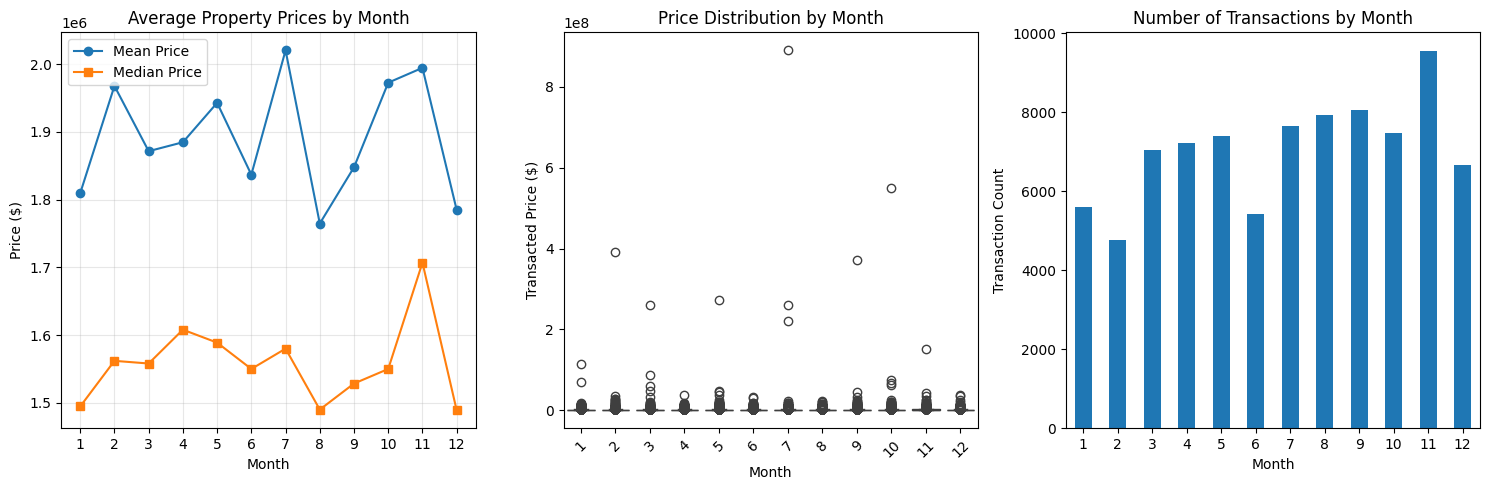


Monthly Statistics:
               mean     median  count
Month                                
1      1.809608e+06  1494653.0   5613
2      1.967951e+06  1562000.0   4767
3      1.871599e+06  1558056.0   7048
4      1.884796e+06  1608000.0   7223
5      1.942993e+06  1588888.0   7403
6      1.836895e+06  1550000.0   5437
7      2.020534e+06  1580000.0   7661
8      1.764758e+06  1490000.0   7931
9      1.847874e+06  1528476.5   8074
10     1.972782e+06  1550000.0   7483
11     1.994676e+06  1707000.0   9551
12     1.784866e+06  1489000.0   6671

Coefficient of Variation in monthly average prices: 4.56%
Price range across months: $1,764,758 - $2,020,534
Difference: $255,776

Quarterly Averages:
Q1 (Jan-Mar): $1,877,988
Q2 (Apr-Jun): $1,893,289
Q3 (Jul-Sep): $1,875,912
Q4 (Oct-Dec): $1,928,721

Quarterly Averages:
Q1 (Jan-Mar): $1,877,988
Q2 (Apr-Jun): $1,893,289
Q3 (Jul-Sep): $1,875,912
Q4 (Oct-Dec): $1,928,721


In [901]:
# Analyze correlation between Month and Transacted Price ($)
print("=== Month vs Transacted Price Analysis ===")
month_price_corr = df['Month'].corr(df['Transacted Price ($)'])
print(f"Correlation between Month and Transacted Price: {month_price_corr:.4f}")

# Statistical interpretation
if abs(month_price_corr) < 0.1:
    strength = "very weak/negligible"
elif abs(month_price_corr) < 0.3:
    strength = "weak"
elif abs(month_price_corr) < 0.5:
    strength = "moderate"
elif abs(month_price_corr) < 0.7:
    strength = "strong"
else:
    strength = "very strong"

print(f"Correlation strength: {strength}")
print(f"Direction: {'positive' if month_price_corr > 0 else 'negative' if month_price_corr < 0 else 'no'} correlation")

# Create visualization
plt.figure(figsize=(15, 5))

# Monthly average prices
plt.subplot(1, 3, 1)
monthly_stats = df.groupby('Month')['Transacted Price ($)'].agg(['mean', 'median', 'count'])
plt.plot(monthly_stats.index, monthly_stats['mean'], marker='o', label='Mean Price')
plt.plot(monthly_stats.index, monthly_stats['median'], marker='s', label='Median Price')
plt.title('Average Property Prices by Month')
plt.xlabel('Month')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

# Box plot by month
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='Month', y='Transacted Price ($)')
plt.title('Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Transacted Price ($)')
plt.xticks(rotation=45)

# Transaction count by month
plt.subplot(1, 3, 3)
monthly_stats['count'].plot(kind='bar')
plt.title('Number of Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Additional statistical tests
print(f"\nMonthly Statistics:")
print(monthly_stats)

# Calculate coefficient of variation for monthly averages
monthly_mean_cv = monthly_stats['mean'].std() / monthly_stats['mean'].mean() * 100
print(f"\nCoefficient of Variation in monthly average prices: {monthly_mean_cv:.2f}%")
print(f"Price range across months: ${monthly_stats['mean'].min():,.0f} - ${monthly_stats['mean'].max():,.0f}")
print(f"Difference: ${monthly_stats['mean'].max() - monthly_stats['mean'].min():,.0f}")

# Check if there's seasonal pattern
q1_months = [1, 2, 3]  # Q1
q2_months = [4, 5, 6]  # Q2  
q3_months = [7, 8, 9]  # Q3
q4_months = [10, 11, 12]  # Q4

q1_avg = df[df['Month'].isin(q1_months)]['Transacted Price ($)'].mean()
q2_avg = df[df['Month'].isin(q2_months)]['Transacted Price ($)'].mean()
q3_avg = df[df['Month'].isin(q3_months)]['Transacted Price ($)'].mean()
q4_avg = df[df['Month'].isin(q4_months)]['Transacted Price ($)'].mean()

print(f"\nQuarterly Averages:")
print(f"Q1 (Jan-Mar): ${q1_avg:,.0f}")
print(f"Q2 (Apr-Jun): ${q2_avg:,.0f}")
print(f"Q3 (Jul-Sep): ${q3_avg:,.0f}")
print(f"Q4 (Oct-Dec): ${q4_avg:,.0f}")

In [902]:
# Create enhanced month features to capture seasonal patterns
print("=== Creating Enhanced Month Features ===")

# Create binary features for high-price months
df['is_peak_season'] = df['Month'].isin([10, 11]).astype(int)  # Oct-Nov spike
df['is_november'] = (df['Month'] == 11).astype(int)  # November has highest median

# Create quarter feature (might be more meaningful than individual months)
df['quarter'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=[1, 2, 3, 4])
df['quarter'] = df['quarter'].astype(int)

# Create cyclical encoding for month (preserves seasonal relationships)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print("New month-related features created:")
print(f"- is_peak_season: {df['is_peak_season'].value_counts().to_dict()}")
print(f"- is_november: {df['is_november'].value_counts().to_dict()}")
print(f"- quarter: {df['quarter'].value_counts().sort_index().to_dict()}")

# Analyze the effectiveness of these new features
print(f"\nCorrelation with Transacted Price:")
month_features = ['Month', 'is_peak_season', 'is_november', 'quarter', 'month_sin', 'month_cos']
for feature in month_features:
    corr = df[feature].corr(df['Transacted Price ($)'])
    print(f"{feature}: {corr:.4f}")

# Check price differences for peak season
peak_avg = df[df['is_peak_season'] == 1]['Transacted Price ($)'].mean()
non_peak_avg = df[df['is_peak_season'] == 0]['Transacted Price ($)'].mean()
print(f"\nPeak season (Oct-Nov) average: ${peak_avg:,.0f}")
print(f"Non-peak season average: ${non_peak_avg:,.0f}")
print(f"Difference: ${peak_avg - non_peak_avg:,.0f} ({((peak_avg - non_peak_avg)/non_peak_avg*100):+.1f}%)")

# November vs other months
nov_avg = df[df['is_november'] == 1]['Transacted Price ($)'].mean()
other_avg = df[df['is_november'] == 0]['Transacted Price ($)'].mean()
print(f"\nNovember average: ${nov_avg:,.0f}")
print(f"Other months average: ${other_avg:,.0f}")
print(f"Difference: ${nov_avg - other_avg:,.0f} ({((nov_avg - other_avg)/other_avg*100):+.1f}%)")

=== Creating Enhanced Month Features ===
New month-related features created:
- is_peak_season: {0: 71718, 1: 17975}
- is_november: {0: 79633, 1: 10060}
- quarter: {1: 18427, 2: 21193, 3: 25047, 4: 25026}

Correlation with Transacted Price:
Month: 0.0013
is_peak_season: 0.0096
is_november: 0.0076
quarter: 0.0033
month_sin: -0.0006
month_cos: -0.0005

Peak season (Oct-Nov) average: $1,985,058
Non-peak season average: $1,872,631
Difference: $112,427 (+6.0%)

November average: $1,994,676
Other months average: $1,882,582
Difference: $112,094 (+6.0%)


In [903]:
df.describe()

,Transacted Price ($),Area (SQFT),Number of Units,Year,Month,start_floor,end_floor,Project Name_Encoded,Street Name_Encoded,is_freehold,...,lease_commencement_year,remaining_lease_years,lease_age_at_sale,lease_maturity_ratio,lease_category_encoded,is_peak_season,is_november,quarter,month_sin,month_cos
count,8.486200e+04,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,8.969300e+04,8.969300e+04,89693.000000,...,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,8.969300e+04,8.969300e+04
mean,1.895198e+06,1070.995628,1.014940,22.077553,6.886580,8.144493,12.137848,1.892786e+06,1.895255e+06,0.290580,...,1423.716098,3015.901096,10.810398,0.072124,0.834536,0.200406,0.112160,2.631844,-7.178567e-02,-1.736122e-03
std,4.675024e+06,2586.435741,1.734926,1.310936,3.363251,8.397073,8.405540,2.950371e+06,1.056083e+06,0.454033,...,911.481247,6503.642468,24.164640,0.093530,0.642881,0.400306,0.315565,1.096156,7.104949e-01,7.000370e-01
min,3.400000e+05,258.340000,1.000000,20.000000,1.000000,-1.000000,-5.000000,3.400000e+05,4.000000e+05,0.000000,...,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00
25%,1.168000e+06,699.660000,1.000000,21.000000,4.000000,1.000000,5.000000,1.310944e+06,1.327687e+06,0.000000,...,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-8.660254e-01,-5.000000e-01
50%,1.563000e+06,958.000000,1.000000,22.000000,7.000000,6.000000,10.000000,1.612458e+06,1.643985e+06,0.000000,...,2009.000000,97.000000,3.000000,0.030303,1.000000,0.000000,0.000000,3.000000,-2.449294e-16,-1.836970e-16
75%,2.133255e+06,1259.390000,1.000000,23.000000,10.000000,11.000000,15.000000,2.118778e+06,2.184539e+06,1.000000,...,2018.000000,9999.000000,12.000000,0.111111,1.000000,0.000000,0.000000,4.000000,5.000000e-01,8.660254e-01
max,8.900000e+08,619834.180000,446.000000,24.000000,12.000000,71.000000,75.000000,3.921800e+08,4.734200e+07,1.000000,...,2024.000000,999967.000000,197.000000,0.733333,4.000000,1.000000,1.000000,4.000000,1.000000e+00,1.000000e+00


In [904]:
df.columns

Index(['Transacted Price ($)', 'Area (SQFT)', 'Number of Units', 'Data_Source',
       'Year', 'Month', 'start_floor', 'end_floor', 'Postal District_2.0',
       'Postal District_3.0', 'Postal District_4.0', 'Postal District_5.0',
       'Postal District_6.0', 'Postal District_7.0', 'Postal District_8.0',
       'Postal District_9.0', 'Postal District_10.0', 'Postal District_11.0',
       'Postal District_12.0', 'Postal District_13.0', 'Postal District_14.0',
       'Postal District_15.0', 'Postal District_16.0', 'Postal District_17.0',
       'Postal District_18.0', 'Postal District_19.0', 'Postal District_20.0',
       'Postal District_21.0', 'Postal District_22.0', 'Postal District_23.0',
       'Postal District_25.0', 'Postal District_26.0', 'Postal District_27.0',
       'Postal District_28.0', 'Type of Sale_Resale', 'Type of Sale_Sub Sale',
       'Type of Area_Strata', 'Property Type_Condominium',
       'Market Segment_Outside Central Region',
       'Market Segment_Rest of Cen

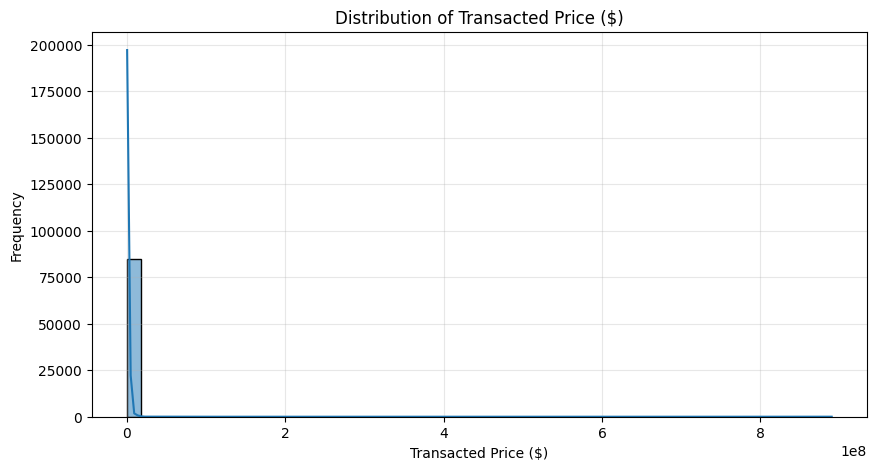

In [905]:
# Plot distribution of target variable
plt.figure(figsize=(10, 5))
sns.histplot(df['Transacted Price ($)'], bins=50, kde=True)
plt.title('Distribution of Transacted Price ($)')
plt.xlabel('Transacted Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

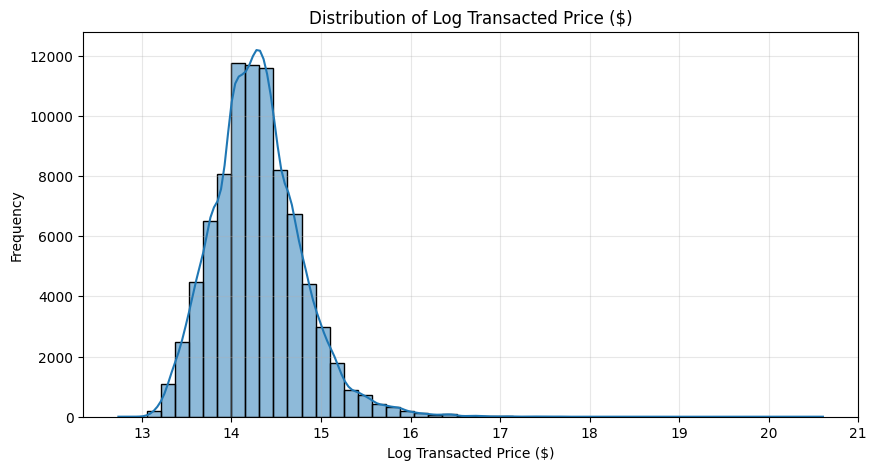

In [906]:
# Plot distribution of log transformed target variable

plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df['Transacted Price ($)']), bins=50, kde=True)
plt.title('Distribution of Log Transacted Price ($)')
plt.xlabel('Log Transacted Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [907]:
# check using train mask if test or train data have any missing values
train_mask = df['Data_Source'] == 'train'
print("Missing values in Train data:")
print(df[train_mask].isna().sum())
print("\nMissing values in Test data:")
print(df[~train_mask].isna().sum())
# get the overall missing values
print("\nOverall missing values:")
print(df.isna().sum())

Missing values in Train data:
Transacted Price ($)                     0
Area (SQFT)                              0
Number of Units                          0
Data_Source                              0
Year                                     0
Month                                    0
start_floor                              0
end_floor                                0
Postal District_2.0                      0
Postal District_3.0                      0
Postal District_4.0                      0
Postal District_5.0                      0
Postal District_6.0                      0
Postal District_7.0                      0
Postal District_8.0                      0
Postal District_9.0                      0
Postal District_10.0                     0
Postal District_11.0                     0
Postal District_12.0                     0
Postal District_13.0                     0
Postal District_14.0                     0
Postal District_15.0                     0
Postal District_16.0    

In [908]:
# convert the target variable to log scale to reduce skewness
# only for training data
train_mask = df['Data_Source'] == 'train'
df.loc[train_mask, 'Log Transacted Price ($)'] = np.log1p(df.loc[train_mask, 'Transacted Price ($)'])
df.drop(columns=['Transacted Price ($)'], inplace=True)

In [909]:
df.columns

Index(['Area (SQFT)', 'Number of Units', 'Data_Source', 'Year', 'Month',
       'start_floor', 'end_floor', 'Postal District_2.0',
       'Postal District_3.0', 'Postal District_4.0', 'Postal District_5.0',
       'Postal District_6.0', 'Postal District_7.0', 'Postal District_8.0',
       'Postal District_9.0', 'Postal District_10.0', 'Postal District_11.0',
       'Postal District_12.0', 'Postal District_13.0', 'Postal District_14.0',
       'Postal District_15.0', 'Postal District_16.0', 'Postal District_17.0',
       'Postal District_18.0', 'Postal District_19.0', 'Postal District_20.0',
       'Postal District_21.0', 'Postal District_22.0', 'Postal District_23.0',
       'Postal District_25.0', 'Postal District_26.0', 'Postal District_27.0',
       'Postal District_28.0', 'Type of Sale_Resale', 'Type of Sale_Sub Sale',
       'Type of Area_Strata', 'Property Type_Condominium',
       'Market Segment_Outside Central Region',
       'Market Segment_Rest of Central Region', 'Project N

## Step 4: Feature Scaling and Selection

In [910]:
df.describe()

,Area (SQFT),Number of Units,Year,Month,start_floor,end_floor,Project Name_Encoded,Street Name_Encoded,is_freehold,lease_duration_years,...,remaining_lease_years,lease_age_at_sale,lease_maturity_ratio,lease_category_encoded,is_peak_season,is_november,quarter,month_sin,month_cos,Log Transacted Price ($)
count,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,8.969300e+04,8.969300e+04,89693.000000,89693.000000,...,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,89693.000000,8.969300e+04,8.969300e+04,84862.000000
mean,1070.995628,1.014940,22.077553,6.886580,8.144493,12.137848,1.892786e+06,1.895255e+06,0.290580,3026.711494,...,3015.901096,10.810398,0.072124,0.834536,0.200406,0.112160,2.631844,-7.178567e-02,-1.736122e-03,14.292072
std,2586.435741,1.734926,1.310936,3.363251,8.397073,8.405540,2.950371e+06,1.056083e+06,0.454033,6499.471400,...,6503.642468,24.164640,0.093530,0.642881,0.400306,0.315565,1.096156,7.104949e-01,7.000370e-01,0.495451
min,258.340000,1.000000,20.000000,1.000000,-1.000000,-5.000000,3.400000e+05,4.000000e+05,0.000000,60.000000,...,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00,12.736704
25%,699.660000,1.000000,21.000000,4.000000,1.000000,5.000000,1.310944e+06,1.327687e+06,0.000000,99.000000,...,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-8.660254e-01,-5.000000e-01,13.970804
50%,958.000000,1.000000,22.000000,7.000000,6.000000,10.000000,1.612458e+06,1.643985e+06,0.000000,99.000000,...,97.000000,3.000000,0.030303,1.000000,0.000000,0.000000,3.000000,-2.449294e-16,-1.836970e-16,14.262118
75%,1259.390000,1.000000,23.000000,10.000000,11.000000,15.000000,2.118778e+06,2.184539e+06,1.000000,9999.000000,...,9999.000000,12.000000,0.111111,1.000000,0.000000,0.000000,4.000000,5.000000e-01,8.660254e-01,14.573160
max,619834.180000,446.000000,24.000000,12.000000,71.000000,75.000000,3.921800e+08,4.734200e+07,1.000000,999999.000000,...,999967.000000,197.000000,0.733333,4.000000,1.000000,1.000000,4.000000,1.000000e+00,1.000000e+00,20.606732


In [911]:
# Split the data into features and target variable
X = df.drop(columns=['Log Transacted Price ($)'])
y = df['Log Transacted Price ($)']  # Use log-transformed target (handles skewness better)

X_train = X[X['Data_Source'] == 'train'].drop(columns=['Data_Source'])
X_test = X[X['Data_Source'] == 'test'].drop(columns=['Data_Source'])
y_train = y[X['Data_Source'] == 'train']


In [912]:
# check if X_train has any na values
print("Number of missing values in X_train:", X_train.isna().sum().sum())
print("Number of missing values in X_test:", X_test.isna().sum().sum())

Number of missing values in X_train: 0
Number of missing values in X_test: 0


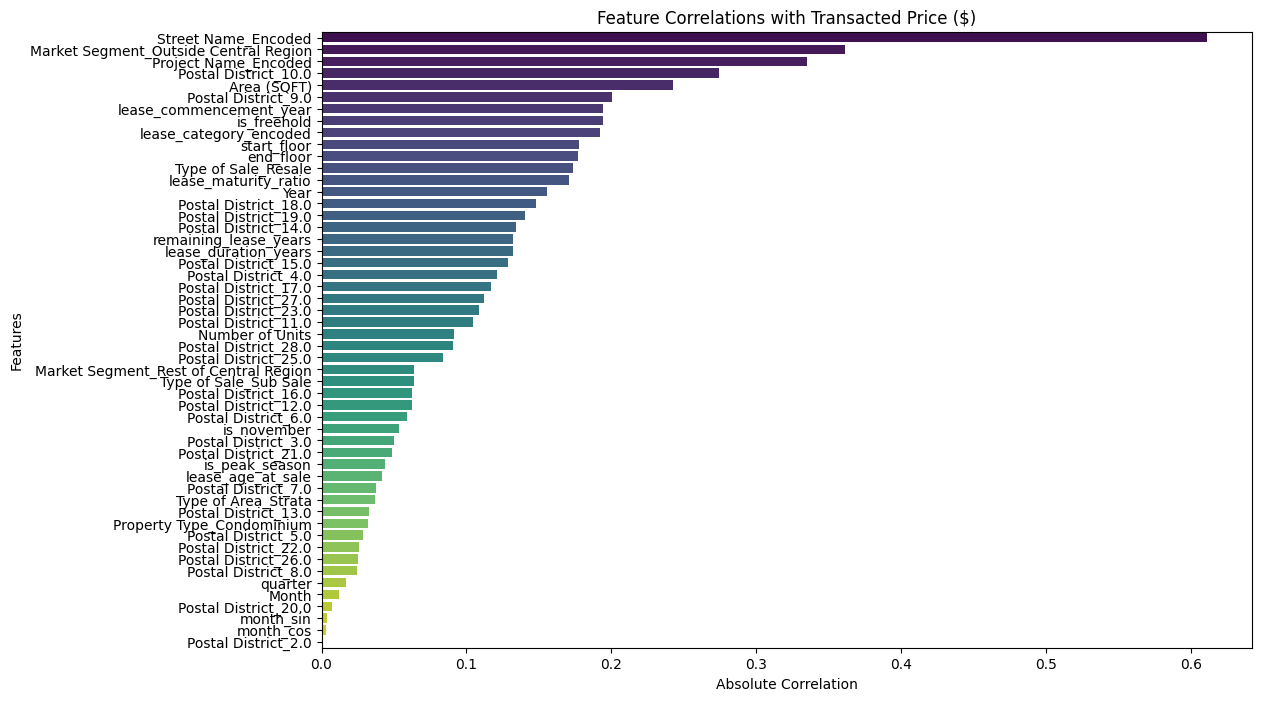

In [913]:
# Plot correlations between features and target variable
plt.figure(figsize=(12, 8))
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.title('Feature Correlations with Transacted Price ($)')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.show()

Normalizing the training data and using the same scaling to normalize the test data

In [914]:
# Import additional ML models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Initialize models with reasonable hyperparameters
# Note: SVR removed due to slow performance on large datasets
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=15),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Store results
results = {}

# STEP 1: Split BEFORE any feature selection or scaling to prevent data leakage
print("STEP 1: Creating train/validation split BEFORE feature selection and scaling...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)
print(f"Training split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")

# STEP 2: Scale training split and apply to validation split
print("\nSTEP 2: Scaling features...")
train_scaler = StandardScaler()
X_train_split_scaled = train_scaler.fit_transform(X_train_split)  # Fit only on training split
X_val_split_scaled = train_scaler.transform(X_val_split)      # Apply scaling to validation
X_test_scaled = train_scaler.transform(X_test)  # Apply same scaling to test set

# Note: No need to scale y (target) for regression - it's already log-transformed

# STEP 3: Feature selection using Lasso (ONLY on training split)
print("\nSTEP 3: Feature selection with Lasso (only on training split)...")
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_split_scaled, y_train_split)  # Only use training split for feature selection

print(f"Best alpha: {lasso.alpha_}")
lasso_coef = pd.Series(lasso.coef_, index=X_train.columns)
important_features = lasso_coef[lasso_coef != 0].index
print(f"Features selected by Lasso: {len(important_features)} out of {len(X_train.columns)}")
print("Top 10 selected features:")
print(lasso_coef[lasso_coef != 0].sort_values(ascending=False, key=abs).head(10))

# Apply feature selection to both training and validation splits
X_train_split_selected = X_train_split[important_features]
X_val_split_selected = X_val_split[important_features]
X_train_split_selected_scaled = X_train_split_scaled[:, [i for i, col in enumerate(X_train.columns) if col in important_features]]
X_val_split_selected_scaled = X_val_split_scaled[:, [i for i, col in enumerate(X_train.columns) if col in important_features]]

print(f"Final feature matrix shapes:")
print(f"Training split (selected features): {X_train_split_selected.shape}")
print(f"Validation split (selected features): {X_val_split_selected.shape}")

# STEP 4: Train and evaluate models with proper data selection
print(f"\nSTEP 4: Training models with {len(important_features)} Lasso-selected features...")

# Note: Each model is trained only ONCE with proper train/val split, feature selection, and scaling
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Choose whether to use scaled or unscaled data based on model type
    # IMPORTANT: Now using the Lasso-selected features!
    if name in ['Linear Regression', 'K-Nearest Neighbors']:
        # These models benefit from scaling - use selected features with scaling
        X_train_model = X_train_split_selected_scaled
        X_val_model = X_val_split_selected_scaled
    else:
        # Tree-based models don't need scaling - use selected features without scaling
        X_train_model = X_train_split_selected
        X_val_model = X_val_split_selected
    
    # Train model on training split (using appropriate X features, same y target for all)
    model.fit(X_train_model, y_train_split)
    
    # Evaluate on validation split (truly unseen data)
    y_val_pred_log = model.predict(X_val_model)
    mse = mean_squared_error(y_val_split, y_val_pred_log)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_split, y_val_pred_log)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
    }
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

# Create results summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

results_df = pd.DataFrame(results).T
print("Results sorted by R² (descending):")
results_df_r2 = results_df.sort_values('R²', ascending=False)
print(results_df_r2.round(2))

print("\nResults sorted by MSE (ascending - lower is better):")
results_df_mse = results_df.sort_values('MSE', ascending=True)
print(results_df_mse.round(2))

# Find best model based on MSE (lowest MSE is best)
best_model_mse = results_df_mse.index[0]
print(f"\n🏆 BEST MODEL (based on MSE): {best_model_mse}")
print(f"   MSE: {results_df.loc[best_model_mse, 'MSE']:.4f}")
print(f"   RMSE: {results_df.loc[best_model_mse, 'RMSE']:.4f}")
print(f"   R²: {results_df.loc[best_model_mse, 'R²']:.4f}")

# Calculate improvement over Linear Regression (using MSE-based best model)
lr_mse = results_df.loc['Linear Regression', 'MSE']
lr_r2 = results_df.loc['Linear Regression', 'R²']
lr_rmse = results_df.loc['Linear Regression', 'RMSE']

best_mse = results_df.loc[best_model_mse, 'MSE']
best_r2 = results_df.loc[best_model_mse, 'R²']
best_rmse = results_df.loc[best_model_mse, 'RMSE']

mse_improvement = ((lr_mse - best_mse) / lr_mse) * 100
r2_improvement = ((best_r2 - lr_r2) / lr_r2) * 100
rmse_improvement = ((lr_rmse - best_rmse) / lr_rmse) * 100

if best_model_mse != 'Linear Regression':
    print(f"\n📈 IMPROVEMENT OF {best_model_mse} OVER LINEAR REGRESSION:")
    print(f"   MSE improvement: -{mse_improvement:.4f}% (lower is better)")
    print(f"   RMSE improvement: -{rmse_improvement:.4f}% (lower is better)")
    print(f"   R² improvement: +{r2_improvement:.4f}% (higher is better)")
else:
    print(f"\n✅ Linear Regression has the lowest MSE!")

STEP 1: Creating train/validation split BEFORE feature selection and scaling...
Training split: (59403, 52)
Validation split: (25459, 52)

STEP 2: Scaling features...

STEP 3: Feature selection with Lasso (only on training split)...
Best alpha: 0.0028272730160061087
Features selected by Lasso: 39 out of 52
Top 10 selected features:
Area (SQFT)                              1.318837
Number of Units                         -1.227645
Type of Sale_Resale                     -0.124001
Street Name_Encoded                      0.112818
Year                                     0.087084
Market Segment_Outside Central Region   -0.082108
Market Segment_Rest of Central Region   -0.035940
lease_category_encoded                  -0.034236
Property Type_Condominium                0.034109
Project Name_Encoded                    -0.032390
dtype: float64
Final feature matrix shapes:
Training split (selected features): (59403, 39)
Validation split (selected features): (25459, 39)

STEP 4: Training models

=== RANDOM FOREST INTERPRETABILITY ANALYSIS ===
⚠️  IMPORTANT: Re-run the model comparison cell first after fixing data leakage!
   The previous results included the target variable as a feature (data leakage)
   New results will be much more realistic.


1. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
Top 10 Most Important Features:
                                  feature  importance
33                   Project Name_Encoded    0.494765
0                             Area (SQFT)    0.392561
27                    Type of Sale_Resale    0.021297
2                                    Year    0.020091
34                    Street Name_Encoded    0.019964
36                   lease_maturity_ratio    0.011344
35                      lease_age_at_sale    0.008350
31  Market Segment_Outside Central Region    0.004690
5                               end_floor    0.004155
4                             start_floor    0.004058

2. INDIVIDUAL TREE ANALYSIS
-------

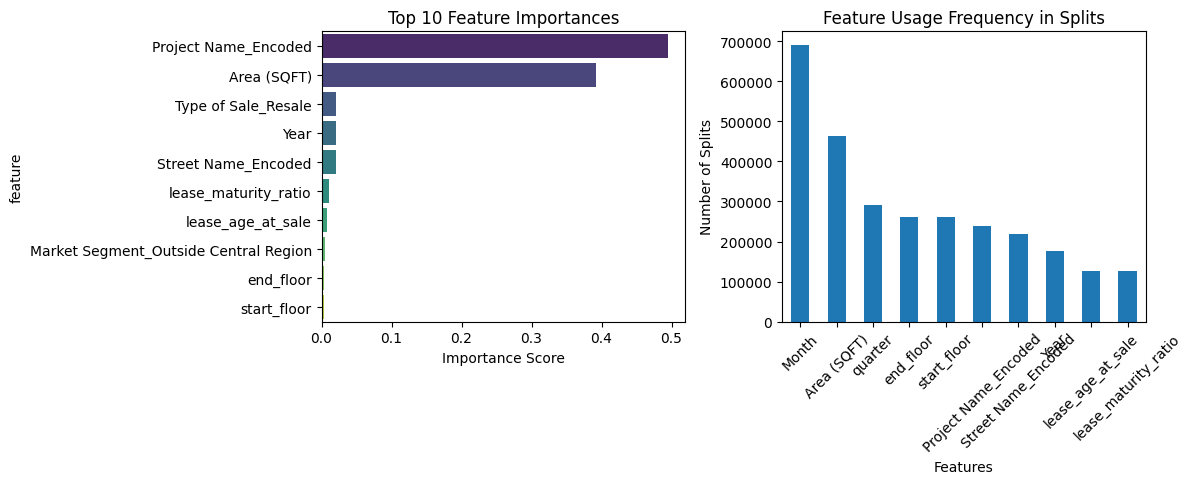

In [915]:
# Random Forest Interpretability Analysis
print("=== RANDOM FOREST INTERPRETABILITY ANALYSIS ===")
print("⚠️  IMPORTANT: Re-run the model comparison cell first after fixing data leakage!")
print("   The previous results included the target variable as a feature (data leakage)")
print("   New results will be much more realistic.\n")

# First, let's retrain the Random Forest to get access to the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_split_selected, y_train_split)

# 1. FEATURE IMPORTANCE ANALYSIS
print("\n1. FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': important_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')

# 2. INDIVIDUAL TREE ANALYSIS
print(f"\n2. INDIVIDUAL TREE ANALYSIS")
print("-" * 50)

# Analyze one tree in detail
tree_to_analyze = 0  # First tree
individual_tree = rf_model.estimators_[tree_to_analyze]

print(f"Tree {tree_to_analyze} Statistics:")
print(f"- Tree depth: {individual_tree.tree_.max_depth}")
print(f"- Number of nodes: {individual_tree.tree_.node_count}")
print(f"- Number of leaves: {individual_tree.tree_.n_leaves}")

# Get tree structure information
def get_tree_split_info(tree, feature_names):
    """Extract split information from a decision tree"""
    tree_ = tree.tree_
    splits_info = []
    
    def recurse(node_id, depth=0):
        if tree_.feature[node_id] != -2:  # Not a leaf
            feature_name = feature_names[tree_.feature[node_id]]
            threshold = tree_.threshold[node_id]
            splits_info.append({
                'node_id': node_id,
                'depth': depth,
                'feature': feature_name,
                'threshold': threshold,
                'samples': tree_.n_node_samples[node_id],
                'impurity': tree_.impurity[node_id]
            })
            
            # Recurse on children
            recurse(tree_.children_left[node_id], depth + 1)
            recurse(tree_.children_right[node_id], depth + 1)
    
    recurse(0)
    return pd.DataFrame(splits_info)

# Get splits for the first tree
tree_splits = get_tree_split_info(individual_tree, important_features)
print(f"\nTop 10 splits in Tree {tree_to_analyze} (by number of samples):")
print(tree_splits.nlargest(10, 'samples')[['depth', 'feature', 'threshold', 'samples', 'impurity']])

# 3. AGGREGATE SPLIT ANALYSIS ACROSS ALL TREES
print(f"\n3. AGGREGATE SPLIT ANALYSIS")
print("-" * 50)

# Collect all splits from all trees
all_splits = []
for i, tree in enumerate(rf_model.estimators_):
    tree_splits = get_tree_split_info(tree, important_features)
    tree_splits['tree_id'] = i
    all_splits.append(tree_splits)

all_splits_df = pd.concat(all_splits, ignore_index=True)

# Analyze most common split features
split_frequency = all_splits_df['feature'].value_counts()
print("Most frequently used features for splits:")
print(split_frequency.head(10))

# Analyze split thresholds for top features
print(f"\nSplit threshold statistics for top 3 features:")
for feature in split_frequency.head(3).index:
    feature_splits = all_splits_df[all_splits_df['feature'] == feature]['threshold']
    print(f"\n{feature}:")
    print(f"  - Times used for splits: {len(feature_splits)}")
    print(f"  - Threshold range: {feature_splits.min():.2f} to {feature_splits.max():.2f}")
    print(f"  - Most common threshold: {feature_splits.mode().iloc[0]:.2f}")
    print(f"  - Median threshold: {feature_splits.median():.2f}")

plt.subplot(2, 2, 2)
split_frequency.head(10).plot(kind='bar')
plt.title('Feature Usage Frequency in Splits')
plt.xlabel('Features')
plt.ylabel('Number of Splits')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [916]:
# OPTIONAL: TREE VISUALIZATION (Uncomment if you want to see actual tree structure)
# Note: This creates large visualizations, so use sparingly

# Visualize a single tree (requires graphviz: pip install graphviz)
from sklearn.tree import export_graphviz
import graphviz

def visualize_tree(model, tree_idx=0, max_depth=3):
    # Export tree to DOT format
    dot_data = export_graphviz(
        model.estimators_[tree_idx],
        out_file=None,
        feature_names=important_features,
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=max_depth  # Limit depth for readability
    )
    
    # Create graph
    graph = graphviz.Source(dot_data)
    return graph


print(f"\nTREE STRUCTURE (Text Format)")
print("-" * 50)

def print_tree_structure(tree, feature_names, node=0, depth=0, max_depth=3):
    """Print tree structure in text format"""
    if depth > max_depth:
        print("  " * depth + "...")
        return
        
    if tree.tree_.feature[node] != -2:  # Not a leaf
        feature_name = feature_names[tree.tree_.feature[node]]
        threshold = tree.tree_.threshold[node]
        samples = tree.tree_.n_node_samples[node]
        
        print("  " * depth + f"├─ {feature_name} <= {threshold:.2f} (samples: {samples})")
        print_tree_structure(tree, feature_names, tree.tree_.children_left[node], depth + 1, max_depth)
        
        print("  " * depth + f"└─ {feature_name} > {threshold:.2f}")
        print_tree_structure(tree, feature_names, tree.tree_.children_right[node], depth + 1, max_depth)
    else:
        # Leaf node
        prediction = tree.tree_.value[node][0][0]
        samples = tree.tree_.n_node_samples[node]
        print("  " * depth + f"→ Prediction: ${prediction:,.0f} (samples: {samples})")

# Show structure of first tree (limited depth for readability)
print("Structure of Tree 0 (first 3 levels):")
print_tree_structure(rf_model.estimators_[0], important_features, max_depth=2)

# PRACTICAL INSIGHTS FOR YOUR PROPERTY PRICE MODEL
print(f"\n8. PRACTICAL INSIGHTS FOR PROPERTY PRICE PREDICTION")
print("=" * 60)

# Analyze what the model learned about property pricing
area_importance = feature_importance[feature_importance['feature'].str.contains('Area', case=False, na=False)]
tenure_importance = feature_importance[feature_importance['feature'].str.contains('lease|freehold', case=False, na=False)]
location_importance = feature_importance[feature_importance['feature'].str.contains('floor|remaining', case=False, na=False)]

print("Key Property Pricing Factors the Random Forest Learned:")

if not area_importance.empty:
    print(f"\n🏠 AREA/SIZE FACTORS:")
    for _, row in area_importance.head(3).iterrows():
        print(f"   • {row['feature']}: {row['importance']:.4f}")

if not tenure_importance.empty:
    print(f"\n📜 TENURE FACTORS:")
    for _, row in tenure_importance.head(3).iterrows():
        print(f"   • {row['feature']}: {row['importance']:.4f}")

if not location_importance.empty:
    print(f"\n📍 LOCATION/FLOOR FACTORS:")
    for _, row in location_importance.head(3).iterrows():
        print(f"   • {row['feature']}: {row['importance']:.4f}")

print(f"\n🎯 MODEL BEHAVIOR:")
print(f"   • Uses {len(rf_model.estimators_)} trees for predictions")
print(f"   • Average tree depth: {np.mean([tree.tree_.max_depth for tree in rf_model.estimators_]):.1f}")
print(f"   • Most important feature: {feature_importance.iloc[0]['feature']}")
print(f"   • Top 3 features explain {feature_importance.head(3)['importance'].sum():.1%} of decisions")



TREE STRUCTURE (Text Format)
--------------------------------------------------
Structure of Tree 0 (first 3 levels):
├─ Project Name_Encoded <= 1753040.31 (samples: 37586)
  ├─ Area (SQFT) <= 651.22 (samples: 21489)
    ├─ Project Name_Encoded <= 1263780.88 (samples: 5288)
      ...
    └─ Project Name_Encoded > 1263780.88
      ...
  └─ Area (SQFT) > 651.22
    ├─ Project Name_Encoded <= 1293890.25 (samples: 16201)
      ...
    └─ Project Name_Encoded > 1293890.25
      ...
└─ Project Name_Encoded > 1753040.31
  ├─ Area (SQFT) <= 1415.46 (samples: 16097)
    ├─ Area (SQFT) <= 769.62 (samples: 11927)
      ...
    └─ Area (SQFT) > 769.62
      ...
  └─ Area (SQFT) > 1415.46
    ├─ Project Name_Encoded <= 4158688.25 (samples: 4170)
      ...
    └─ Project Name_Encoded > 4158688.25
      ...

8. PRACTICAL INSIGHTS FOR PROPERTY PRICE PREDICTION
Key Property Pricing Factors the Random Forest Learned:

🏠 AREA/SIZE FACTORS:
   • Area (SQFT): 0.3926
   • Type of Area_Strata: 0.0001

📜 TEN